In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
sys.path.append(str(Path.cwd().parent))
from method import InvariantSearch, DirectICP
from utils import create_subset
from dataprep import get_activity, pre_process
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
np.random.seed(1)
# set parameters
a_label = 'send'
e_label = 'user'
y_label = 'y'
min_size = 1

In [4]:
# the lists of features
activity_feature = ['C(decision_bucket)', 'location', 'variation_indicator', 'engagement']
interaction = activity_feature
control_feature = ['square_root_yesterday', 'temperature', 'pre_treatment_steps']
main_effect =  activity_feature + control_feature

# create all candidate subsets
candidate_sets = create_subset(interaction, min_size=min_size)
# create all candidate subsets for direct icp
mapping = {"C(decision_bucket)":[0, 1, 2],
          "location":[3,4],
          "variation_indicator":[5],
          "engagement":[6],
          "dosage":[7]}
candidate_sets_direct = {s:np.concatenate([mapping[x] for x in s]) for s in candidate_sets}

In [5]:
# get the data
activity_df = get_activity()

# preprocess data
all_df = pre_process(activity_df, a_label, e_label)

In [6]:
directICP = DirectICP(interaction=interaction, y_label=y_label)
effectICP = InvariantSearch(activity_feature, control_feature, y_label=y_label)

full_inv = directICP.invariant_search(all_df, candidate_sets_direct)
effect_inv = effectICP.invariant_search(all_df, candidate_sets, method='effect')

In [7]:
# add method ind
full_inv['test'] = 'Full-invariance'
effect_inv['test'] = 'e-invariance'

pval_df = pd.concat([full_inv, effect_inv], ignore_index=True)
pval_df['engagement'] = pval_df.set.str.contains("engagement")

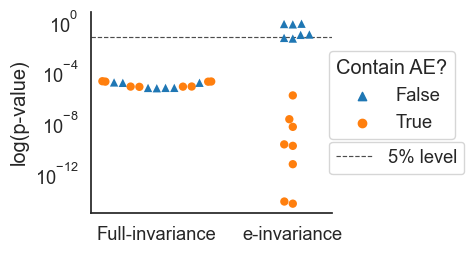

In [8]:
sns.set(font_scale=1.2, style='white', palette=sns.set_palette("tab10"))

g = sns.catplot(data=pval_df, x="test", y="pval", hue="engagement", kind='swarm', 
                dodge=False, size=6, height=3, aspect=1.2)

ax=g.ax

# dummy plots, just to get the Path objects
a = ax.scatter([1,1],[1,1], marker='o')
b = ax.scatter([1,1],[1,1], marker='^')
circle_mk, = a.get_paths()
triangle_up_mk, = b.get_paths()
a.remove()
b.remove()

collections = ax.collections
unique_colors = np.unique(collections[0].get_facecolors(), axis=0)
markers = [triangle_up_mk, circle_mk]
for collection in collections:
    paths = []
    for current_color in collection.get_facecolors():
        for possible_marker,possible_color in zip(markers, unique_colors):
            if np.array_equal(current_color, possible_color):
                paths.append(possible_marker)
                break
    collection.set_paths(paths)
    
g.axes[0][0].set_yscale('log')
g.axes[0][0].set_ylabel("log(p-value)")
g.axes[0][0].set_xlabel("")
g._legend.remove()

l1 = plt.legend(collections[-2:], pd.unique(pval_df.engagement))  
l1.set_bbox_to_anchor([0.95, 0.85])
l1.set_title("Contain AE?")


p1 = plt.axhline(0.05, ls='--', color='black', label='5% level', linewidth=0.85, alpha=0.7)
plt.legend([p1], ["5% level"], bbox_to_anchor=(0.95, 0.4))
g.ax.add_artist(l1)

plt.savefig('invariant_test.pdf', bbox_inches='tight')